In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from os import walk
from tensorflow import keras

In [2]:
data_dir = "./Dados_StoAndre"
start_date = "16/12/2019"
header_names = ["hour", "kwh_h", "ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8", "ch9", "ch10", "tem_h", "avgT", "minT", "maxT"]
files = []

for (_, _, filenames) in walk(data_dir):
    files.extend(filenames)
    break

time_series = pd.date_range(start=start_date, periods=24*len(files) - 13, freq='H')

hist_data = pd.DataFrame()
for i in range(len(files)):
    file = files[i]
    df = pd.read_csv(data_dir + '/' + file, header=None, names=header_names, delim_whitespace=True)
    hist_data = pd.concat([hist_data, df])

hist_data = hist_data.set_index(time_series)
hist_data

,hour,kwh_h,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,tem_h,avgT,minT,maxT
2019-12-16 00:00:00,0,kwh_h,0.324,0.000,0.000,0.000,0.328,0.007,0.0,0.0,0.324,0.336,tem_h,27.3,27.2,27.3
2019-12-16 01:00:00,1,kwh_h,0.231,0.002,0.001,0.000,0.241,0.017,0.0,0.0,0.232,0.259,tem_h,27.1,27.1,27.2
2019-12-16 02:00:00,2,kwh_h,0.264,0.000,0.003,0.001,0.274,0.012,0.0,0.0,0.265,0.290,tem_h,27.0,26.9,27.1
2019-12-16 03:00:00,3,kwh_h,0.137,0.000,0.000,0.001,0.146,0.011,0.0,0.0,0.138,0.158,tem_h,26.8,26.6,26.9
2019-12-16 04:00:00,4,kwh_h,0.164,0.000,0.000,0.000,0.176,0.010,0.0,0.0,0.165,0.186,tem_h,26.5,26.4,26.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14 06:00:00,6,kwh_h,0.157,0.001,0.001,0.000,0.165,0.011,0.0,0.0,0.157,0.177,tem_h,24.1,24.0,24.2
2020-01-14 07:00:00,7,kwh_h,0.137,0.002,0.000,0.000,0.151,0.023,0.0,0.0,0.139,0.174,tem_h,24.0,24.0,24.1
2020-01-14 08:00:00,8,kwh_h,0.484,0.293,0.568,0.000,0.217,0.026,0.0,0.0,0.777,0.811,tem_h,24.1,24.0,24.3
2020-01-14 09:00:00,9,kwh_h,0.292,0.061,0.000,0.119,0.241,0.023,0.0,0.0,0.352,0.384,tem_h,24.4,24.2,24.6


<Figure size 432x288 with 0 Axes>

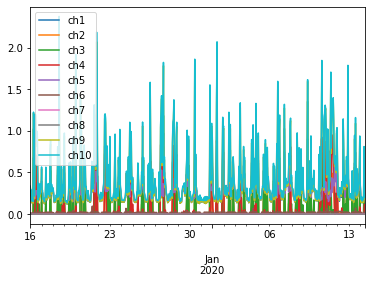

In [3]:
plt.figure()
hist_data.loc[:, 'ch1':'ch10'].plot()

<Figure size 432x288 with 0 Axes>

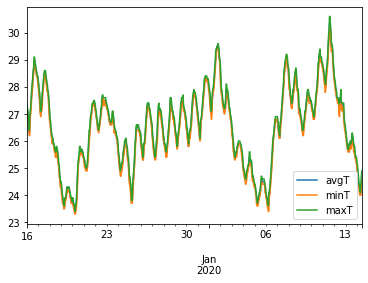

In [4]:
plt.figure()
hist_data.loc[:, 'avgT':'maxT'].plot()

In [5]:
for i in range(1, 11):
    print(hist_data['ch' + str(i)].corr(hist_data['avgT']) * 100)

27.104618669970847
22.29577018599883
0.7321128746806882
34.017063157530906
21.07214981408716
23.349872714114888
12.388903033791117
17.544496881530165
25.55682524475588
26.069201386270045


# Naive Forecast 1
cons(t) = cons(t-1)

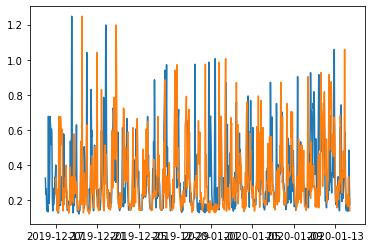

In [6]:
naive_forecast = hist_data.head(-24)
naive_forecast.index = naive_forecast.index + timedelta(days=1)

plt.figure()
plt.plot(hist_data.index, hist_data['ch1'])
plt.plot(naive_forecast.index, naive_forecast['ch1'])

In [7]:
print(keras.metrics.mean_squared_error(hist_data[24:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24:]['ch1'], naive_forecast['ch1']).numpy())

0.05198570131771596
0.14771888726207905


# Naive Forecast
cons(t) = cons(t-7)

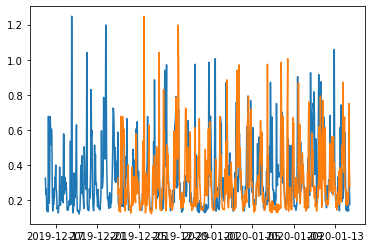

In [8]:
naive_forecast = hist_data.head(-24*7)
naive_forecast.index = naive_forecast.index + timedelta(days=7)

plt.figure()
plt.plot(hist_data.index, hist_data['ch1'])
plt.plot(naive_forecast.index, naive_forecast['ch1'])

In [9]:
print(keras.metrics.mean_squared_error(hist_data[24*7:]['ch1'], naive_forecast['ch1']).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24*7:]['ch1'], naive_forecast['ch1']).numpy())

0.054693641929499076
0.15859183673469393


# Moving Average
cons(t) = (consumo - consumo semana passada) + MA(consumo semana passada)

371
539


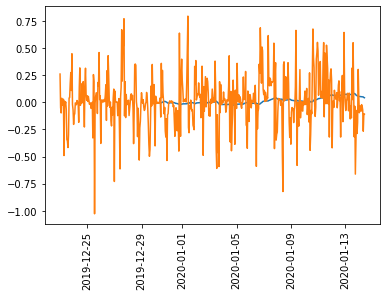

In [10]:
diff = hist_data['ch1'].subtract(naive_forecast['ch1']).tail(-24*7)
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    print(len(forecast))
    print(len(series))
    return pd.DataFrame(data=forecast, index=series.tail(-24*7).index, columns=['ch1'])
ma_diff = moving_average_forecast(diff, 24*7)
plt.plot(ma_diff.index, ma_diff['ch1'])
plt.plot(diff.index, diff)
plt.xticks(rotation=90);

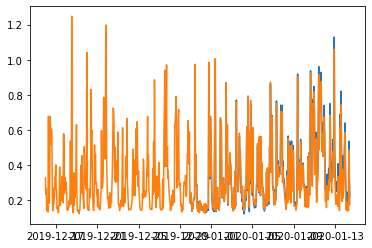

In [11]:
ma_forecast = ma_diff['ch1'].add(hist_data['ch1'].tail(-24*14))
plt.plot(ma_forecast.index, ma_forecast)
plt.plot(hist_data.index, hist_data['ch1'])

In [12]:
print(keras.metrics.mean_squared_error(hist_data[24*14:]['ch1'], ma_forecast).numpy())
print(keras.metrics.mean_absolute_error(hist_data[24*14:]['ch1'], ma_forecast).numpy())

0.001089365019008502
0.023823899371069178
